In [165]:
import numpy as np
from scipy import optimize as opt
import time
from matplotlib import pyplot as plt

## Exercise 1

In [129]:
## First I'll define some useful functions for the 3-period model.
def get_w(bvec, argsw):
    '''
    bvec is a 2-element list, the savings b_2t and b_3t.
    argsw is a parameters vector [nvec, A, alpha]
    Output is w_t the equilibrium wage rate
    '''
    nvec, A, alpha = argsw
    w = (1 - alpha) * A * ((bvec[0] + bvec[1]) / np.sum(nvec)) ** alpha
    return w

get_w([.5, .5],)
def get_r(bvec, argsr):
    '''
    bvec is a 2-element list, the savings b_2t and b_3t.
    argsw is a parameters vector [nvec, A, alpha, delta]
    Output is r_t the equilibrium intrest rate
    '''
    nvec, A, alpha, delta = argsr
    r = alpha * A * (np.sum(nvec) / (bvec[0] +bvec[1])) ** (1 - alpha) - delta
    return r

def feasible(f_params, bvec_guess):
    '''
    fparams is a prameter vector [nvec, A, alpha, delta]
    bvec_guess is the guess for bvec (steady-state savings vector)
    '''
    nvec, A, alpha, delta = f_params
    w = get_w(bvec_guess, [nvec, A, alpha])
    r = get_r(bvec_guess, [nvec, A, alpha, delta])
    #print('w', w, 'r', r)
    b_2, b_3 = bvec_guess[0], bvec_guess[0]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    # K_cnstr = True if capital is <= 0.
    K_cnstr = (b_2 + b_3 <= 0)
    # c_cnstr = True if Consumption <= 0.
    # I get these by plugging into the budget constraints.
    c_1 = w * n_1 - b_2
    c_2 = b_2 * (1+r) + w * n_2 - b_3
    c_3 = b_3 * (1+r) + w * n_3
    #print('c1', c_1, 'c2', c_2, 'c3', c_3)
    c_cnstr = ((c_1 <= 0), (c_2 <= 0), (c_3 <= 0))
    b_cnstr = ((c_cnstr[0] == True | c_cnstr[1] == True), (c_cnstr[1] == True | c_cnstr[2] == True))
    return w, r, b_cnstr, c_cnstr, K_cnstr

print("test for (a)", feasible([[1, 1, .2], 1, .35, .6415], [1.0, 1.2]))
print("test for (b)", feasible([[1, 1, .2], 1, .35, .6415], [.06, -.001]))
print("test for (c)", feasible([[1, 1, .2], 1, .35, .6415], [.1, .1]))
print("test for (c)", feasible([[1, 1, .2], 1, .35, .6415], [.019, .058]))

test for (a) (0.65, -0.2915, (True, False), (True, False, False), False)
test for (b) (0.18317391275691647, 3.036307374780331, (False, False), (False, False, False), False)
test for (c) (0.28081863036662547, 1.021810349094628, (False, False), (False, False, False), False)
test for (c) (0.20106532128214416, 2.45181263510991, (False, False), (False, False, False), False)


In (a) and (b), the first budget constraint of the household is violated. In (c), nothing is violated.

## Exercise 2

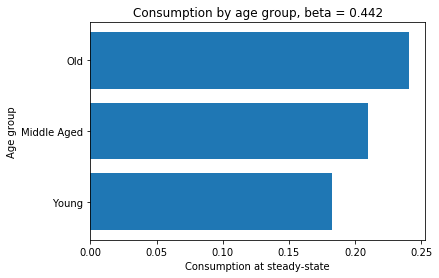

{'b_ss': array([0.01931262, 0.05841243]), 'c_ss': [0.18241332984586706, 0.2096142411367639, 0.2408765622579139], 'w_ss': 0.20172594930955895, 'r_ss': 2.433025771148647, 'K_ss': 0.07772504796372812, 'Y_ss': 0.6827647515092765, 'C_ss': 0.6329041332405448, 'EulErr_ss': array([-0.00253831,  0.0054862 ]), 'RCerr_ss': 9.020562075079397e-17, 'ss_time': 1247.2287691823917}


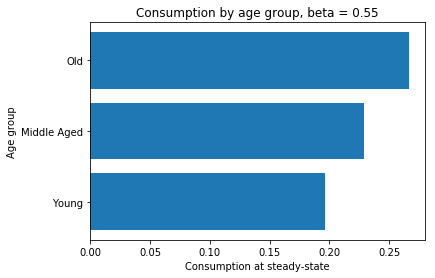

{'b_ss': array([0.02818307, 0.07686099]), 'c_ss': [0.19597038673396155, 0.22863868705115642, 0.2666784110010002], 'w_ss': 0.22415346070701764, 'r_ss': 1.8863500166253273, 'K_ss': 0.10504406365960055, 'Y_ss': 0.7586732516237521, 'C_ss': 0.6912874847861181, 'EulErr_ss': array([ 0.05081364, -0.03801077]), 'RCerr_ss': 2.220446049250313e-16, 'ss_time': 1247.4366214670415}


In [193]:
def uprime(c, sigma):
    '''
    Input is some level of consumption and CRRE parameter sigma
    uprime 
    '''
    if c <= 1e-6:
        uprime = 1e20
    else:
        uprime = c ** (- sigma)
    return uprime
#uprime()

def euler_errors(bvec, params):
    '''
    This function calculates the difference between the euler 
    equations for the age 1 householods and the age 2 households.
    fparams is a prameter vector [nvec, A, alpha, delta]
    bvec_guess is the guess for bvec
    Output is eulerr = [diff1, diff2]
    This is what we will try to set = 0 to optimize
    '''
    #Name things
    nvec, A, alpha, delta, beta, sigma = params
    w = get_w(bvec, [nvec, A, alpha])
    r = get_r(bvec, [nvec, A, alpha, delta])
    b_2, b_3 = bvec[0], bvec[1]
    n_1, n_2, n_3 = nvec[0], nvec[1], nvec[2]
    #Define Euler differences
    eulerr1 = uprime((w - b_2), sigma) - beta * (1 + r) * uprime((w + (1 + r) * b_2 - b_3), sigma)
    eulerr2 = uprime((w + (1 + r) * b_2 - b_3), sigma) - beta * (1+r) * uprime(((1 + r) * b_3 + n_3 * w), sigma)
    return (eulerr1, eulerr2)

#print(euler_errors([1.56e+7, 4.98e+22], [[1, 1, .2], 1, .35, .6415, .442, .3]))

def c(bvec, nvec, w, r):
    c1 = w * nvec[0] - bvec[0]
    c2 = bvec[0] * (1+r) + w * nvec[1] - bvec[1]
    c3 = bvec[1] * (1+r) + w * nvec[2]
    cvec = [c1, c2, c3]
    return cvec

def get_SS(params, bvec_guess, SS_graphs):
    '''
    Inputs are the parameters for the model (defined below), an initial
    guess of the steady sate savings, and a boolean withc tells me to
    plot anything. Output ss_output has a variety of different factors
    which are given in the definition.
    '''
    time.clock()
    beta, sigma, nvec, L, A, alpha, delta, SS_tol = params
    optimizer = opt.root(euler_errors, bvec_guess, args =[nvec, A, alpha, delta, beta, sigma], tol = SS_tol)
    b_ss = optimizer.x
    w_ss = get_w(b_ss, [nvec, A, alpha])
    r_ss = get_r(b_ss, [nvec, A, alpha, delta])
    c_ss = c(b_ss, nvec, w_ss, r_ss)
    K_ss = np.sum(b_ss)
    Y_ss = (A * K_ss ** alpha) * (L ** (1-alpha))
    C_ss = np.sum(c_ss)
    EulErr_ss = optimizer.fun
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    ss_time = time.clock()
    ss_output = {
        'b_ss': b_ss, 'c_ss': c_ss, 'w_ss': w_ss, 'r_ss': r_ss,
        'K_ss': K_ss, 'Y_ss': Y_ss, 'C_ss': C_ss,
        'EulErr_ss': EulErr_ss, 'RCerr_ss': RCerr_ss,
        'ss_time': ss_time}
    if SS_graphs == True:
        plt.barh(["Young", "Middle Aged", "Old"], c_ss)
        plt.ylabel("Age group")
        plt.xlabel("Consumption at steady-state")
        plt.title(f"Consumption by age group, beta = {beta}")
        plt.show()
    return ss_output
        
#Run function
params = [.442, 3, [1, 1, .2], 2.2, 1, .35, .6415, .01]
bvec_guess = [.1,.1]
print(get_SS(params, bvec_guess, SS_graphs = True))

#Now with new beta
params = [.55, 3, [1, 1, .2], 2.2, 1, .35, .6415, .01]
print(get_SS(params, bvec_guess, SS_graphs = True))

When we increase beta, we see that savings in both the young and middle-aged increases. Interestingly, so does consumption in all age groups, but the largest effect is in the old. Wages increase, and interst rates decrease.